### MOREIRA TEIXEIRA Luiz Fernando

**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [1]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="/home/luiz/Documents/Telecom Paris/IMA/IM05 - Apprentissage pour l'image/TP3 - Supervised/data/"    

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Otherwise, you can also load them from your local machine using the following code

In [2]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

Let's load the Python packages containing the functions needed for the practical session.

In [3]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA

We also load a user-defined function useful for plotting the confusion matrix

In [4]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [5]:
# Parameters
dim=2 # dimension   
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

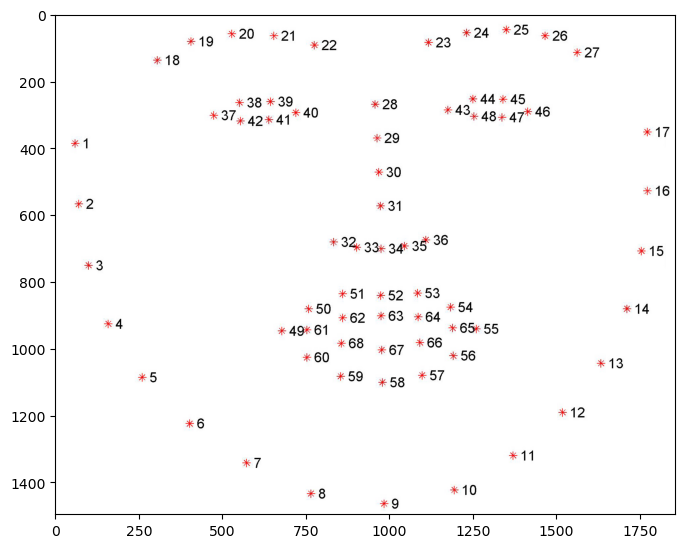

In [6]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

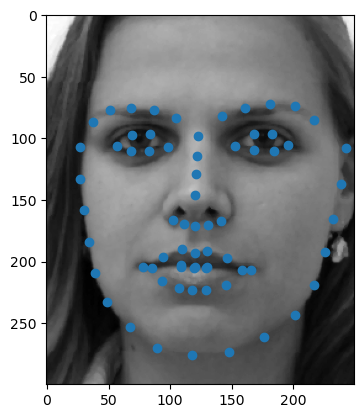

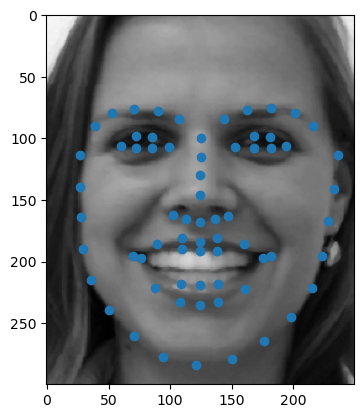

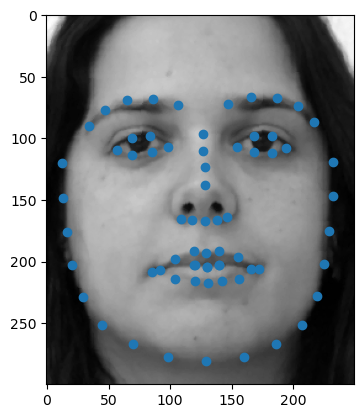

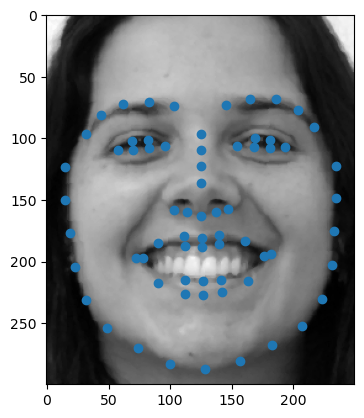

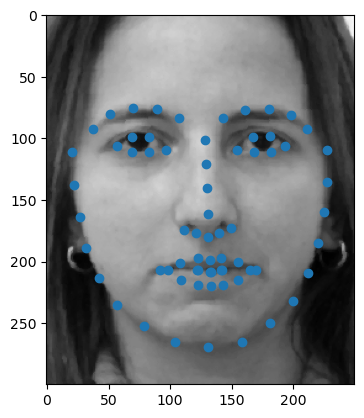

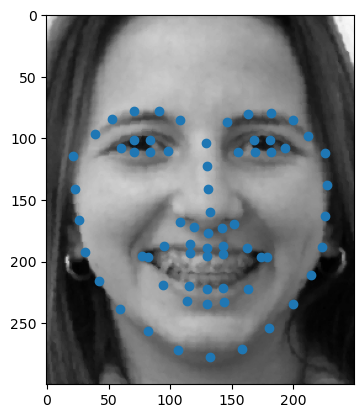

In [7]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?


It's possible to notice that we always have two pictures of the same subject, one with a neutral expression followed by a happy one of the same subject. So its 2 pictures of the same subject and this repeats for every different subject. 

Given that, it would be worth it to randomly shuffle all the data in order to separate the pictures beloging to the same subject with different expressions, this gives us a better generalization.


---



In [8]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indeces = np.arange(len(Images))
np.random.shuffle(indeces)

XpGPA=XGPA[indeces]
Xp=X[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]
Xmean = np.mean(XpGPA,axis=0) # Compute average

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]   



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


**QUESTION**: Please comment the results. What can you notice ?

**Answer:**

After applying Generalized Procrustes Analysis (GPA), the variation in facial landmarks, especially around the mouth, is greatly reduced. This makes the aligned landmarks more reliable for identifying subjects and detecting facial expressions.




---



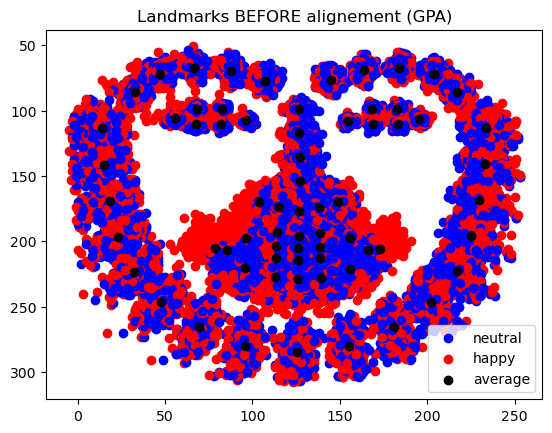

In [9]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')
plt.show()

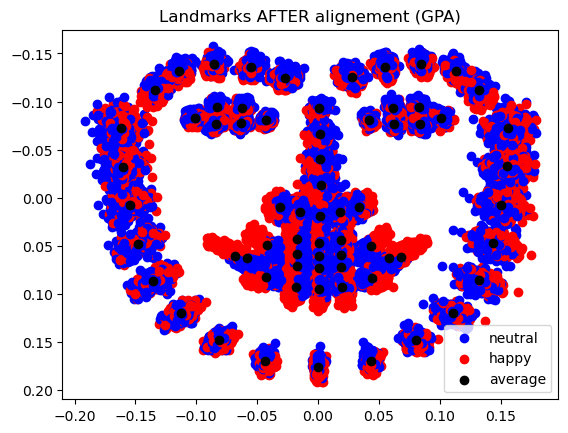

In [10]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')
plt.show()



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the landmarks of every subject and the landmarks of the average configuration. 



---



In [11]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
average=np.reshape(Xmean,(M,2)) # Reshape average as matrix

for i in range(N):
    landmark = np.reshape(XpGPA[i], (M, 2)) # Reshape all landmarks as matrices
    dist_average[i]=  np.linalg.norm(landmark - average, axis=1)

print('Number of subjects N is: ', dist_average.shape[0], ' ; number of features is: ',  dist_average.shape[1] )


Number of subjects N is:  400  ; number of features is:  68


Let's divide the data-set into Training and Test sets:

In [12]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

**Answer:**

Often in Machine Learning we need to scale/normalize our data. Many models perform better when they are applied in normalized/scaled data. Since we are working with euclidian distances, that is strongly affected scale. Thus we should perform normalization/scaling in this case.




Please note that we compute the parameters of 'StandardScaler()' and 'MinMaxScaler()' using only the training set and then we trasform both the traning and test sets using the parameters learnt only on the training set.

**Question**: Why do we do that in your opinion ?

**Answer:**

It's important to fit only the training set and then apply the transformation using these parameters for the training, validation and test set. 

Since we are training the model with the training set, our model expects similar distributions, if we fit/transform all sets inidividually our model won't be able to apply what he learned properly to the validation/test sets. 

Moreover if we fit and apply the transformation before dividing the sets, we're taking the risk of having a data leakage. Our training data should not have access to information from the test set, since the test set represents real-world unseen data.

---

In [13]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler

normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)




---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.

**Answer:** 

They all had the same performance, same confusion matrix.



---



Fitting LDA to training set
done in 0.005s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 640x480 with 0 Axes>

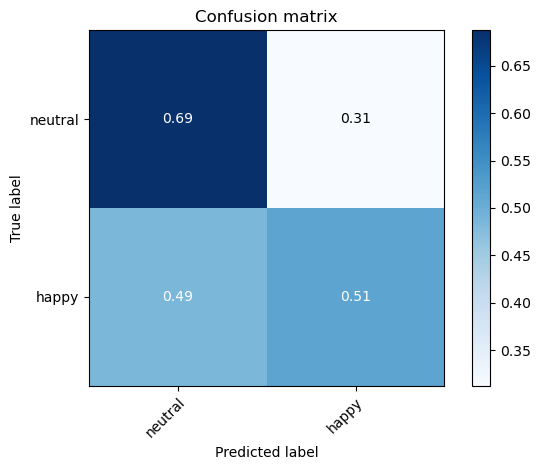

In [14]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

done in 0.006s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 640x480 with 0 Axes>

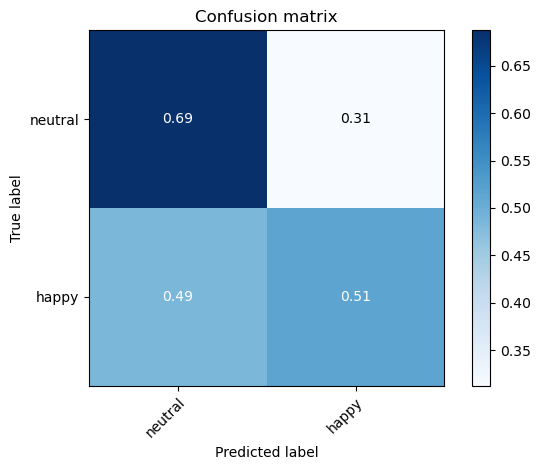

In [15]:
# Fitting LDA to scaled data
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred_scaled = lda.predict(X_test_scale)

print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred_scaled))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_scaled)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

done in 0.005s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 640x480 with 0 Axes>

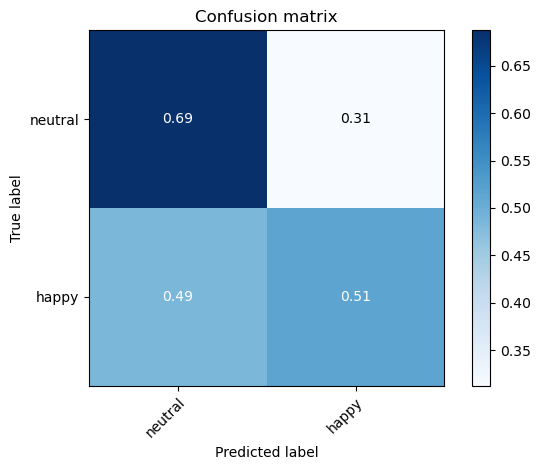

In [16]:
# Fitting LDA to normalized data
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normalize, y_train)
y_pred_normalize = lda.predict(X_test_normalize)

print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred_normalize))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_normalize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---

We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

---






In [17]:
# Cross-validation for Model Assessment


# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis(reg_param=0.1)
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.026s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.026s
 Average and std CV score : 0.5800000000000001 +- 0.012747548783981964
Fitting Logistic Regression
done in 0.018s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.013s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.054s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


---
**Question**: compare the performances between original, scaled and normalized data

Be careful, if you want to standardize your data within a cross validation it means that you should fit 'StandardScaler()' only to the K-1 training folds without using the K-th test fold ! And then transform all folds.
How can we do that ? 

Scikit-learn gives us a very nice tool: THE PIPELINE ! It makes it easier to chain standardization, normalizations, etc. with estimators during a cross validation. Please have a look here: https://scikit-learn.org/stable/common_pitfalls.html

How can we build a Pipeline? It's very simple. Just concatenate the trasformation and the the estimator you want to use:

model = make_pipeline(StandardScaler(), LinearRegression())

---


### **Comparison of Model Performance: Original vs Standardized vs Normalized Data**

| **Model**              | **Original Data** | **Standardized (`StandardScaler`)** | **Normalized (`MinMaxScaler`)** | **Best Approach** |
|------------------------|------------------|------------------------------------|--------------------------------|------------------|
| **LDA**               | **0.5575** ± 0.0451 | **0.5575** ± 0.0451 | **0.5575** ± 0.0451 | No impact |
| **QDA**               | **0.5800** ± 0.0127 | **0.5975** ± 0.0242 | **0.6075** ± 0.0545 | **Normalization improved it!** |
| **Logistic Regression** | **0.5350** ± 0.0483 | **0.5500** ± 0.0177 | **0.5700** ± 0.0358 | **Normalization improved it!** |
| **Naïve Bayes (GNB)**  | **0.5725** ± 0.0588 | **0.5725** ± 0.0588 | **0.5725** ± 0.0588 | No impact |
| **k-NN (k=3)**        | **0.6050** ± 0.0322 | **0.5625** ± 0.0137 | **0.5725** ± 0.0339 | **Original performed best!** |


In [18]:
# Cross-validation for Model Assessment with Standaridzation

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis(reg_param=0.1))
qda_score = cross_val_score(qda, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting GNB")
t0 = time()
GNB = make_pipeline(StandardScaler(), GaussianNB())
GNB_score = cross_val_score(GNB, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))


# Fitting K-nearest neighbour
print("Fitting KNN")
t0 = time()
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.038s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.036s
 Average and std CV score : 0.5975 +- 0.02423839928708163
Fitting Logistic-regression
done in 0.082s
 Average and std CV score : 0.55 +- 0.01767766952966367
Fitting GNB
done in 0.022s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting KNN
done in 0.023s
 Average and std CV score : 0.5625 +- 0.013693063937629145


In [19]:
# Cross-validation for Model Assessment with Normalization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis(reg_param=0.1))
qda_score = cross_val_score(qda, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting GNB")
t0 = time()
GNB = make_pipeline(MinMaxScaler(), GaussianNB())
GNB_score = cross_val_score(GNB, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))


# Fitting K-nearest neighbour
print("Fitting KNN")
t0 = time()
neigh = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh, X=dist_average, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.036s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.038s
 Average and std CV score : 0.6075 +- 0.05454356057317857
Fitting Logistic-regression
done in 0.046s
 Average and std CV score : 0.57 +- 0.03588175023601831
Fitting GNB
done in 0.021s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting KNN
done in 0.023s
 Average and std CV score : 0.5725 +- 0.033911649915626375



---

In the previous example we have fixed the hyper-parameter K to 3. We could use CV to find the best value.

---



In [20]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



In [21]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))

The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091




---



**Question**: Comment the results of the two previous experiments. What about the best K and validation/test error ? Are the results the same ? Why in your opinion ?

**Answer:**

The first experiment uses all the data set for the training. We obtained K = 7, as being the best with an average validation score equal to  0.64.

As for the second experiment we used only a part of the data set for the training. As a result we obtained a different K = 5 with an average validation score equal to  0.60 and a test score of 0.66.

Both experiments used the same GridSearch Parameters. But we can consider the second experiment as being a better than the first one since generalization of the model is being considered. This means that for unseen data we're perfoming better than the first one.



---





---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [22]:
from itertools import combinations
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))

# Compute pairwise distances
for i in range(N):
    landmark = np.reshape(XGPA[i], (M, 2))  # Convert flattened landmark vector into (M,2) shape

    # Compute pairwise Euclidean distances
    pairwise_distances = [
        np.linalg.norm(landmark[p1] - landmark[p2])
        for p1, p2 in combinations(range(M), 2)  # Iterate over all unique landmark pairs
    ]

    dist_combination[i] = pairwise_distances  # Store computed distances

print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )


Number of subjects N is:  400  ; number of features is:  2278


In [23]:
X2_train, X2_test, y2_train, y2_test = train_test_split(dist_combination, np.ravel(Yp), test_size=0.33, random_state=42)

**Question**: Should we scale/normalize the new features ?

**Answer:** 

Yes, we should scale or normalize the new features because they represent Euclidean distances between facial landmarks, which can vary significantly in magnitude. Scaling ensures that all features contribute equally to the model's learning process, preventing certain distances from dominating others.

Use the classification algorithms seen before to test the discriminative power of the new features. 

In [24]:
# Cross-validation for Model Assessment with Standaridzation

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis(reg_param=0.9))
qda_score = cross_val_score(qda, X=dist_combination, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit, X=dist_combination, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting GNB")
t0 = time()
GNB = make_pipeline(StandardScaler(), GaussianNB())
GNB_score = cross_val_score(GNB, X=dist_combination, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))


# Fitting K-nearest neighbour
print("Fitting KNN")
t0 = time()
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh, X=dist_combination, y=np.ravel(Yp), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.719s
 Average and std CV score : 0.46499999999999997 +- 0.0532681893816563
Fitting QDA


/home/luiz/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/luiz/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/luiz/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/luiz/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of param

done in 0.475s
 Average and std CV score : 0.4774999999999999 +- 0.04834769901453427
Fitting Logistic-regression
done in 0.429s
 Average and std CV score : 0.465 +- 0.05937171043518958
Fitting GNB
done in 0.095s
 Average and std CV score : 0.485 +- 0.06633249580710798
Fitting KNN
done in 0.077s
 Average and std CV score : 0.48249999999999993 +- 0.04077376607575023




---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. 

**Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the predictive power of the new features.

**Answer:**

We can use PCA to reduce dimensionality thus reducing collinearity/redudancy in our data.



---



In [25]:
# Scaling

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# PCA

pca = PCA()
X2_train_pca = pca.fit_transform(X2_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The optimal number of components to retain 95% variance is: {n_components_95}")



The optimal number of components to retain 95% variance is: 16


In [26]:
pca_optimal = PCA(n_components=n_components_95)
X2_train_pca_optimal = pca_optimal.fit_transform(X2_train_scaled)
X2_test_pca_optimal = pca_optimal.transform(X2_test_scaled)

In [27]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=X2_train_pca_optimal, y=np.ravel(y2_train),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis(reg_param=0.9))
qda_score = cross_val_score(qda, X=X2_train_pca_optimal, y=np.ravel(y2_train), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit, X=X2_train_pca_optimal, y=np.ravel(y2_train), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting GNB")
t0 = time()
GNB = make_pipeline(StandardScaler(), GaussianNB())
GNB_score = cross_val_score(GNB, X=X2_train_pca_optimal, y=np.ravel(y2_train), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))


# Fitting K-nearest neighbour
print("Fitting KNN")
t0 = time()
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh, X=X2_train_pca_optimal, y=np.ravel(y2_train), cv =5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.022s
 Average and std CV score : 0.45877009084556253 +- 0.03583686278028959
Fitting QDA
done in 0.017s
 Average and std CV score : 0.46247379454926624 +- 0.06005662214625356
Fitting Logistic-regression
done in 0.020s
 Average and std CV score : 0.46254367575122296 +- 0.03180585158391191
Fitting GNB
done in 0.016s
 Average and std CV score : 0.46240391334730957 +- 0.03221333921978132
Fitting KNN
done in 0.017s
 Average and std CV score : 0.4895178197064989 +- 0.08466706762986302




---


A second solution, would be to manually select few landmarks



---



In [28]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


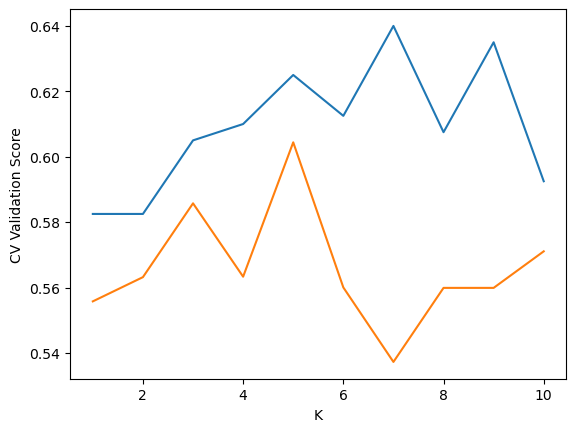

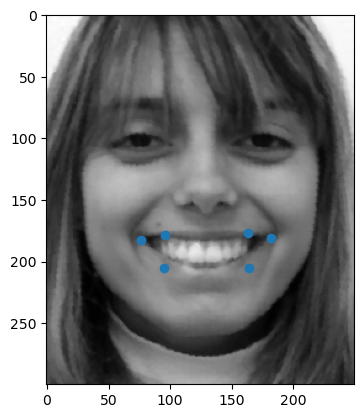

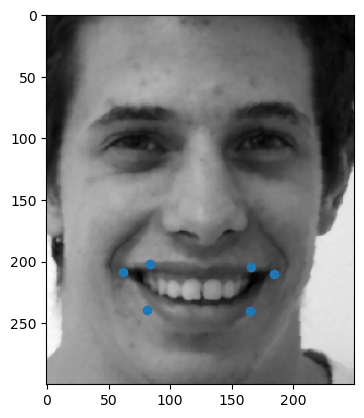

In [29]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

In [30]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [31]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


---

Let's plot some images where the best model was wrong. 

---

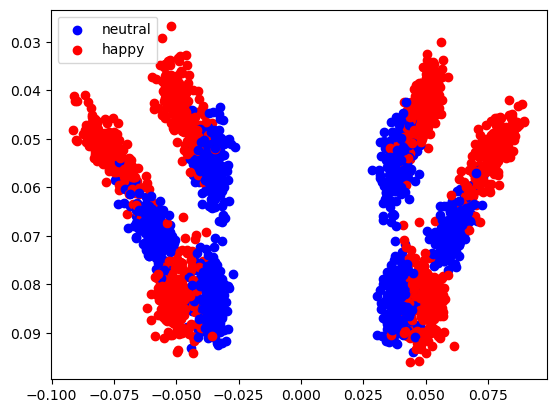

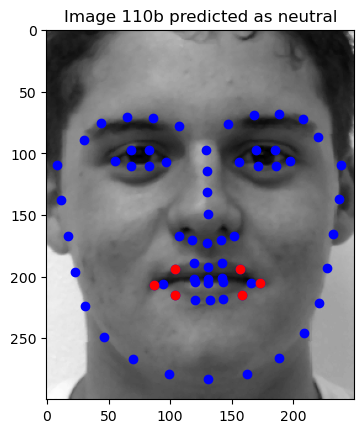

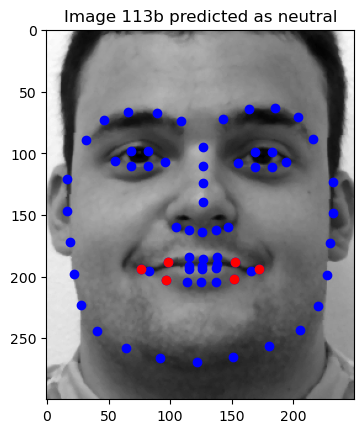

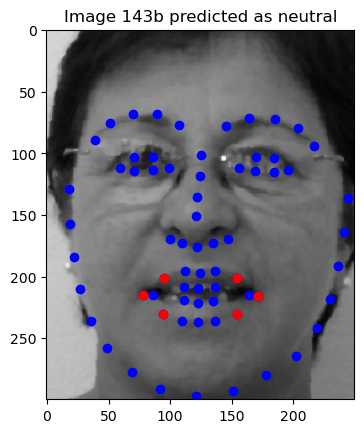

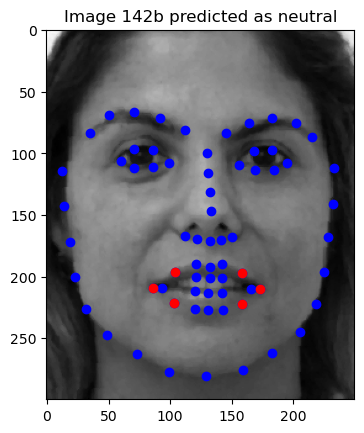

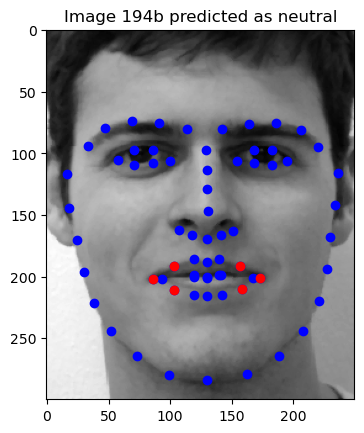

In [32]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks

The algorithm made a mistake possibly because the subjects being analyzed didn't move much their mouth where the landmarks are located, thus making it difficult to differentiate neutral from happy in our model. 


In [33]:
# Select lateral landmarks mouth
select_land=[i for i in range(32,69)]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  74


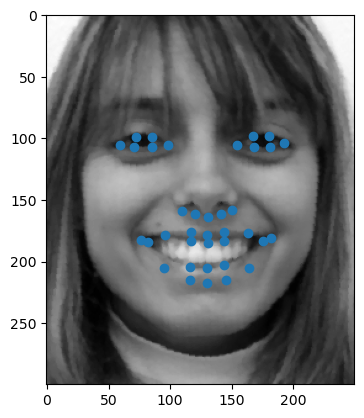

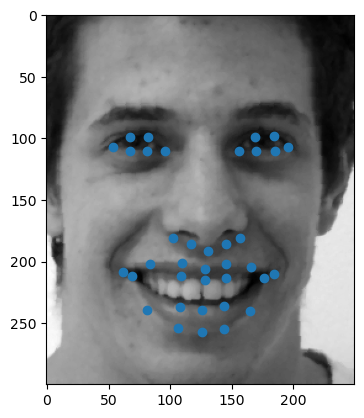

In [34]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

In [35]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [36]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.9893749999999999 +- 0.004677071733467446
 Average and std test score : 0.945 +- 0.021794494717703377


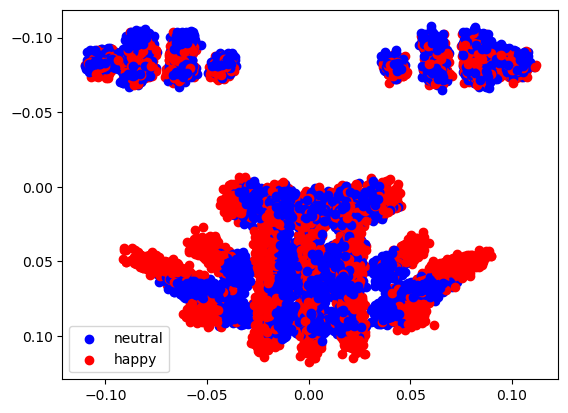

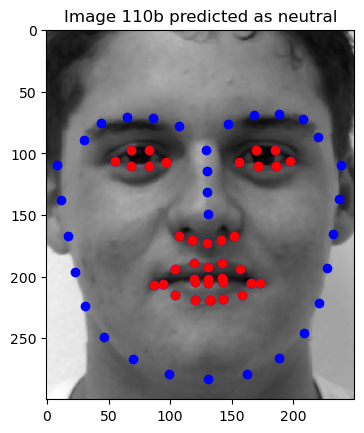

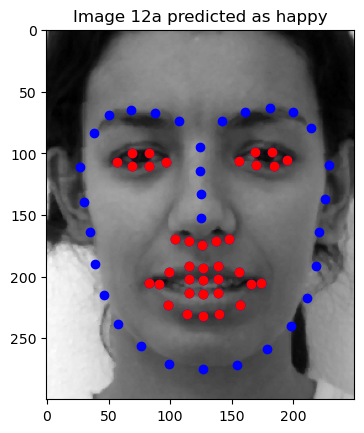

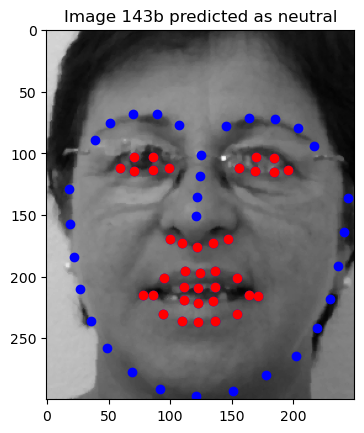

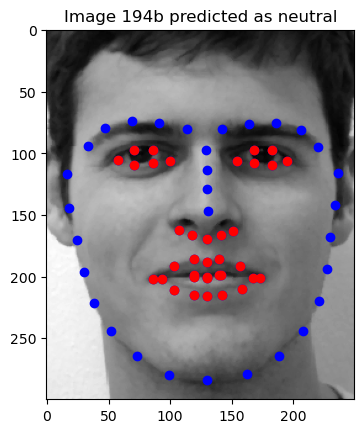

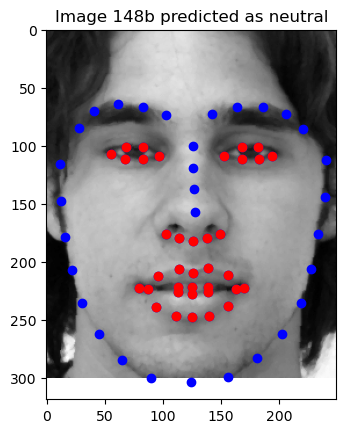

In [37]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [38]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 0.322s
Average and std Nested Cv train score : 0.9712500000000001 +- 0.004999999999999982
Average and std Nested Cv test score : 0.9675 +- 0.012747548783981983


---

**Question**: Are Training and Test scores similar ? What does it mean ?

**Answer:**

Training and tests scores are relatively close. This indicates that our model has succesfully been able to generalize the data and it's working well for unseen data.

---

**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power


**Answer:**

We notice that expressions from neutral to happy the most important landmarks, the ones that will move the most, are located in the eyes, below the nose and the mouth. 

So, good landmarks to choose are everything from 32 to 68.
